In [1]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from bgm import *
from sagan import *
from causal_model import *
from load_data import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
root_folder = 'dataset/celebA/'
img_dim = 64

cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
num_label = len(cols)

A = torch.zeros((num_label, num_label))
A[0, 2:6] = 1
A[1, 4] = 1
saved_folder = 'saved_model'
#saved_folder = 'saved_model_downsample_smile_reduce_latent_dim'

In [4]:
in_channels = 3
fc_size = 2048
latent_dim = 100

g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)
checkpoint = torch.load(f'{saved_folder}/bgm', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to(device)

In [5]:
file_name = "dear_train_downsample_smile"
df = pd.read_csv(f"dataset/celebA/{file_name}.csv").replace(-1,0)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,103180.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,192717.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,195928.jpg,0,0,0,1,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
3,171431.jpg,0,0,0,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,166913.jpg,1,0,0,1,0,0,0,1,1,...,0,1,1,0,0,0,0,0,1,0


In [6]:
root_folder = 'dataset/celebA/'
dest_dir = 'synthetic_dataset/'
dest_img_folder = dest_dir+"img/"

make_dir = lambda path : os.makedirs(path) if not os.path.exists(path) else 0
make_dir(dest_dir)
make_dir(dest_dir+"img")

# Sampling from majority attribute to minority attribute within a class

* Smiling = 0, Male = 1 ----> Smiling = 0, Male = 0  
* Smiling = 1, Male = 0 ----> Smiling = 1, Male = 1   

In [7]:
y_name, attr_name = 'Smiling', 'Male'
final_cols = [y_name, attr_name]

In [8]:
img_folder = f"{root_folder}img/img_align_celeba/"

In [9]:
class ImageDataset(Dataset):
    def __init__(self, root_folder, df, transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/img_align_celeba/'
        self.attr = df.copy()
        self.image_names = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)
        return image, label, index

def get_dataloader(root_folder, df, img_dim=64, batch_size=32, cols = None):
    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    data = ImageDataset(root_folder=root_folder, df = df, transform=transform, cols = cols)
    dataloader = DataLoader(data, batch_size = batch_size, shuffle = True)
    return dataloader

In [10]:
idx_attr = cols.index(attr_name)
idx_y = cols.index(y_name)

batch_size = 256
make_samples = 40000

In [11]:
new_imgs_ids_l = []
new_attr_l = []
new_y_l = []

### Conversion 1
* Smiling = 0, Male = 1 ----> Smiling = 0, Male = 0  
* Not Smiling, From Male to Female

In [12]:
df_temp = df[(df['Smiling']==0) & (df['Male']==1)].reset_index(drop=True)
print('Number of rows available for conversion : ', len(df_temp))

Number of rows available for conversion :  40556


In [13]:
dc1_loader = get_dataloader(root_folder, df_temp, batch_size = batch_size)

In [14]:
def save_fig(img_batch, img_id, folder):
    for idx, img in enumerate(img_batch):
        img = Image.fromarray(img.astype(np.uint8)).convert('RGB')
        img_path = folder+str(img_id[idx])+"_t.jpg"
        img.save(img_path)

In [15]:
attr_new , y_new = 0, 0
with torch.no_grad():
    for x, label, index in dc1_loader:
        x = x.to(device)
        eps = model.encode(x)
        eps[:, idx_attr] = -2 if attr_new == 0 else 2
        eps[:, idx_y] = -2 if y_new == 0 else 2
        label_z = model.prior(eps[:, :num_label])
        other_z = eps[:, num_label:]
        z = torch.cat([label_z, other_z], dim=1)
        new_img = model.decoder(z)
        new_img = np.transpose(new_img.cpu().numpy(), (0, 2, 3, 1))
        new_img = (new_img*0.5 + 0.5) * 255
        prev_img_id = list(df_temp.iloc[index]['image_id'])
        prev_img_id = [x.replace(".jpg","") for x in prev_img_id]
        save_fig(new_img, prev_img_id, dest_img_folder)
        new_imgs_ids_l = new_imgs_ids_l + [i+"_t.jpg" for i in prev_img_id]
        new_attr_l = new_attr_l + [attr_new for _ in range(len(prev_img_id))]
        new_y_l = new_y_l + [y_new for _ in range(len(prev_img_id))]
        if len(new_y_l) > make_samples:
            break

### Conversion 2
* Smiling = 1, Male = 0 ----> Smiling = 1, Male = 1

In [16]:
df_temp = df[(df['Smiling']==1) & (df['Male']==0)].reset_index(drop=True)
print('Number of rows available for conversion : ', len(df_temp))

Number of rows available for conversion :  51066


In [17]:
dc2_loader = get_dataloader(root_folder, df_temp, batch_size = batch_size)

attr_new , y_new = 1, 1
with torch.no_grad():
    for x, label, index in dc1_loader:
        x = x.to(device)
        # Get the value in the unit-space
        eps = model.encode(x)
        # Get the prior
        eps[:, idx_attr] = -2 if attr_new == 0 else 2
        eps[:, idx_y] = -1 if y_new == 0 else 1
        label_z = model.prior(eps[:, :num_label])
        # Intervene
        other_z = eps[:, num_label:]
        z = torch.cat([label_z, other_z], dim=1)
        # Get new img based on the new prior
        new_img = model.decoder(z)
        new_img = np.transpose(new_img.cpu().numpy(), (0, 2, 3, 1))
        new_img = (new_img*0.5 + 0.5) * 255
        prev_img_id = list(df_temp.iloc[index]['image_id'])
        prev_img_id = [x.replace(".jpg","") for x in prev_img_id]
        save_fig(new_img, prev_img_id, dest_img_folder)
        new_imgs_ids_l = new_imgs_ids_l + [i+"_t.jpg" for i in prev_img_id]
        new_attr_l = new_attr_l + [attr_new for _ in range(len(prev_img_id))]
        new_y_l = new_y_l + [y_new for _ in range(len(prev_img_id))]
        if len(new_y_l) > 2*make_samples:
            break

In [18]:
import shutil
def copy_img(src_path, dest_path):
    shutil.copy(src_path, dest_path)

In [19]:
for idx,row in df.iterrows():
    image_id = row['image_id']
    attr_val = row[attr_name]
    y_val = row[y_name]
    src_ = f'{img_folder}{image_id}'
    dst_ = dest_img_folder+image_id
    copy_img(src_, dst_)
    new_imgs_ids_l.append(image_id) 
    new_attr_l.append(attr_val) 
    new_y_l.append(y_val)

In [20]:
new_df = pd.DataFrame.from_dict({
    'image_id':new_imgs_ids_l,
    f'{attr_name}' : new_attr_l, 
    f'{y_name}':new_y_l
})

In [21]:
new_df.to_csv(dest_dir+"generated_smiling.csv", index=False)

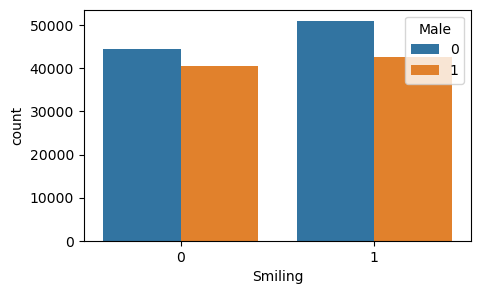

In [22]:
plt.figure(figsize=(5,3))
sns.countplot(data = new_df, x = y_name, hue =attr_name)
plt.show()